In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Capstone_Accenture4/Meet2/Missing data

Mounted at /content/drive
/content/drive/MyDrive/Capstone_Accenture4/Meet2/Missing data


#### Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow import keras

### Global

In [ ]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'Canada',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


### Data

Use (country_code, imputation_method) to store corresponding df
- m_dfs: manufacturing data
- s_dfs: service data

In [ ]:
%cd /content/drive/MyDrive/Capstone_Accenture4/LSTM/Data
Data_dic_m = pd.ExcelFile('Manufacturing.1.xlsx')
Data_dic_s = pd.ExcelFile('Service.1.xlsx')

/content/drive/MyDrive/Capstone_Accenture4/LSTM/Data


In [ ]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names)):
    sheet = Data_dic_m.sheet_names[i]
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[sheet[:3]] = df

In [ ]:
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names)):
    sheet = Data_dic_s.sheet_names[i]
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    s_dfs[sheet[:3]] = df

### Scaling

In [ ]:
class MRobustScaler():
      """
      Scale features using statistics that are robust to outliers.
      """
      def __init__(self, q1=0.2, q2=0.8):
          self.q1 = q1
          self.q2 = q2

      def fit(self, df, eps):
          """
          Return quantile range and median of all features

          Set qrange be 1 if feature has very small range, otherwise calculate
          the quantile range with specified quantile
          """
          df = df.astype('float64') # convert object to float
          self.df_median = df.median() #pd median uses np.nanmedian
          df_q1 = df.quantile(self.q1)
          df_q2 = df.quantile(self.q2)
          qrange = np.array(df_q2 - df_q1) #Near constant features have a very small range
          if np.isscalar(qrange):
                if qrange < eps:
                      qrange = 1.0
          elif isinstance(qrange, np.ndarray):
                constant_mask = qrange < np.ones_like(qrange)*eps
                qrange[constant_mask] = 1.0
          self.qrange = qrange
          self.df_qrange = pd.Series(index = self.df_median.index, data=qrange)
          return self.qrange, self.df_median
      
      def get_fitted(self):
        return self.df_median, self.qrange

      def transform(self, df, eps = 0.1):
          qrange, df_median = self.fit(df, eps = eps)
          return (df - df_median)/qrange

##### ** problem: using quantile scaler, but also median imputation method cause 0

### Make dataset

#### Split dataset 

In [ ]:
def train_test_split(df, train_ratio = 0.7, val_ratio = 0.9, IW = 3):
  """
  By default: train:val:test = 0.7:0.2:0.1
  """
  n = len(df)
  train_df = df[0:int(n*train_ratio)]
  val_df = df[(int(n*train_ratio)-IW):int(n*val_ratio)]
  test_df = df[(int(n*val_ratio)-IW):]
  return train_df, val_df, test_df

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, scaled_data,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.scaled_data = scaled_data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def all_data(self):
    return self.make_dataset(self.scaled_data)

#### Model

In [ ]:
class LSTM_base:

  def __init__(self, lookback_width, num_features, loss=None, layer1=512, layer2=256, layer3=256, label_width=1):
    self.lookback_width = lookback_width
    self.num_features = num_features
    self.loss = loss 
    self.layer1 = layer1
    self.layer2 = layer2
    self.layer3 = layer3
    self.label_width = label_width
    self.create_model()
    self.history = None

  def create_model(self):
    input = layers.Input(shape=(self.lookback_width, self.num_features), name='input')
    x = layers.LSTM(self.layer1, return_sequences=True)(input)
    x = layers.Dropout(0.05)(x)
    x = layers.LSTM(self.layer3)(x)
    output = layers.Dense(self.label_width)(x)
    model = keras.Model(input, outputs=output)
    self.model = model

  def compile_and_fit(self, data_window, epochs, batch_size, verbose, learning_rate, patience=4):
    loss=self.loss,
    history = History()
    batch_size = batch_size[0] if isinstance(batch_size, tuple) else batch_size
    self.model.compile(loss=loss,
                       optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    self.history = self.model.fit(data_window.train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=data_window.val, 
                                  callbacks=[history, EarlyStopping(monitor='val_loss',
                                                           patience=patience,
                                                           mode='min',
                                                           restore_best_weights=True)],
                                  verbose=verbose,
                                  shuffle=False)
    return self.history

  def plot(self):
    display(tf.keras.utils.plot_model(self.model, show_shapes=True))
  
  def train(self, data_window, MAX_EPOCHS, bs, verbose, lr, patience):
    start = time()
    self.data_window = data_window
    self.compile_and_fit(data_window=data_window,
                                epochs=MAX_EPOCHS,
                                batch_size=bs,
                                verbose=verbose,
                                learning_rate=lr,
                                patience=patience)
    delta=time()-start
    self.delta = delta
    print('Total Modelling Time: ',delta)

#### Evaluation

MAE, MSE, RMSE, COD (Coefficient of Determination)

In [ ]:
def fetch_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.test)
  y_pred = np.array(y_pred)*qrange+target_median
  y_real = np.array([y*qrange+target_median for _, y in model.data_window.test]).reshape(y_pred.shape)
  return y_pred, y_real

In [ ]:
def MAE(y_pred, y_real, verbose = 1):
  E = y_pred-y_real
  return np.mean(np.abs(E), axis = 0), np.mean(np.abs(E))

def MSE(y_pred, y_real):
  E = y_pred-y_real
  return np.mean(np.square(E), axis = 0), np.mean(np.square(E))

def RMSE(y_pred, y_real):
  np.sqrt(MSE(y_pred, y_real)[0])
  return np.sqrt(MSE(y_pred, y_real)[0]), np.sqrt(MSE(y_pred, y_real)[1])

In [ ]:
def fetch_all_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.all_data)
  y_pred = np.array(y_pred)*qrange+target_median
  y = None
  for _, j in  model.data_window.all_data:
    if y is None:
      y = j*qrange+target_median
    else:
      y = np.concatenate((y, j*qrange+target_median))
  if type(y) != 'numpy':
    y_real = y.numpy().reshape(y_pred.shape)
  else:
    y_real = y.reshape(y_pred.shape)
  return y_pred, y_real

In [ ]:
def pat_pred(y, data):
  """
  y could be y_real or y_pred
  """
  d = pd.DataFrame({})
  for i in range(y.shape[1]):
    d[f'gap_{i}'] =  [np.nan] * i + list(y[:, i]) + [np.nan] * (y.shape[1]-i-1)
  d.index = data[IW:].index
  return d

In [ ]:
def forecast(rbscaler, scaled_data, model, name = 'Manufacturing_value added_%_of_GDP',IW=3):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y = model.model.predict(np.expand_dims(scaled_data.iloc[-IW:, :], axis = 0))
  df =  pd.DataFrame({name: (np.array(y)*qrange+target_median).tolist()[0]}, index =  [scaled_data.index[-1]+i for i in range(1, 6)])
  return df

### Pipeline

Pipeline example of china

#### China - Median - Multi

In [ ]:
SHIFT = 5
LW = 5
IW = 4
MAX_EPOCHS = 100
bs = 16
verbose = True
lr = 0.005
patience = 50
LOSS = tf.keras.losses.MeanAbsoluteError()

In [ ]:
def clean_nan(data):
  data = data.replace('..', np.nan)
  # drop all column 0
  data = data.dropna(axis=1, how='all')
  # drop nan row according to target
  data = data[data['Manufacturing_value added_%_of_GDP'].notna()]
  return data.fillna(data.median())

In [ ]:
data = m_dfs['CHN']
data = clean_nan(data)
rbscaler = MRobustScaler() 
scaled_data = rbscaler.transform(data, 0.1)

In [ ]:
train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
# use 4 year to predict 1 year ahead
wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                     train_df = train_df, val_df = val_df, test_df = test_df, 
                     scaled_data = scaled_data,
                     label_columns=[scaled_data.columns[-1]])
wg

Total window size: 9
Input indices: [0 1 2 3]
Label indices: [4 5 6 7 8]
Label column name(s): ['Manufacturing_value added_%_of_GDP']

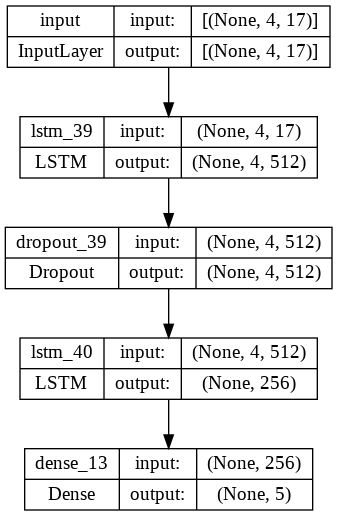

In [ ]:
model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
model.plot()

In [ ]:
model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.1631 - val_loss: 0.5723
Epoch 2/100
1/1 [==============================] - 0s 100ms/step - loss: 0.7009 - val_loss: 0.3598
Epoch 3/100
1/1 [==============================] - 0s 95ms/step - loss: 0.1857 - val_loss: 0.3590
Epoch 4/100
1/1 [==============================] - 0s 90ms/step - loss: 0.1174 - val_loss: 0.3753
Epoch 5/100
1/1 [==============================] - 0s 94ms/step - loss: 0.0756 - val_loss: 0.3539
Epoch 6/100
1/1 [==============================] - 0s 92ms/step - loss: 0.1066 - val_loss: 0.3332
Epoch 7/100
1/1 [==============================] - 0s 97ms/step - loss: 0.0801 - val_loss: 0.3381
Epoch 8/100
1/1 [==============================] - 0s 85ms/step - loss: 0.0590 - val_loss: 0.3177
Epoch 9/100
1/1 [==============================] - 0s 90ms/step - loss: 0.0698 - val_loss: 0.2784
Epoch 10/100
1/1 [==============================] - 0s 85ms/step - loss: 0.0733 - val_loss: 0.2660
Epoch 11/100
1/1 [==

In [ ]:
y_pred, y_real = fetch_pred_real(rbscaler, model)
print(
'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
'\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
'\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
)

1/1 [==============================] - 1s 656ms/step
MAE [3.1260478, 3.2591064, 2.5259304, 3.327526, 1.9052944]  Mean MAE 2.8287811 
MSE [9.862886, 10.63121, 7.5715528, 11.673767, 4.121963]  Mean MSE 8.772276 
RMSE [3.1405232, 3.2605536, 2.7516456, 3.4166894, 2.0302618] Mean RMSE 2.9618027


##### Forecast

1/1 [==============================] - 0s 50ms/step


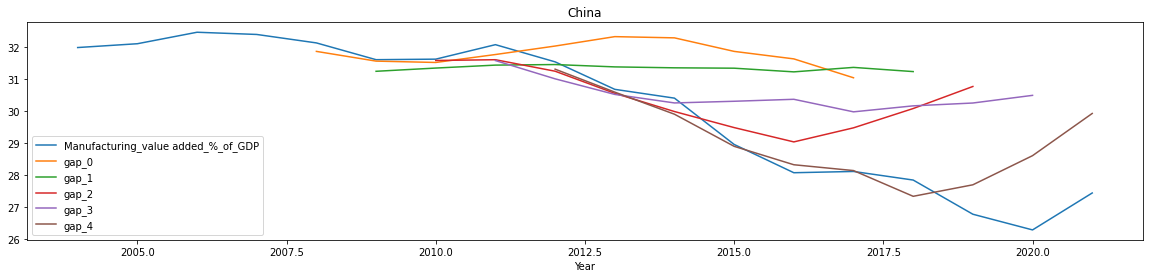

In [ ]:
y_pred, y_real = fetch_all_pred_real(rbscaler, model)
### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1).plot(figsize = (20, 4), title = 'China')

In [ ]:
forecast(rbscaler, scaled_data, model, IW=IW)

1/1 [==============================] - 1s 664ms/step


,Manufacturing_value added_%_of_GDP
2022,30.766291
2023,31.127508
2024,31.863171
2025,31.918928
2026,33.105392


1/1 [==============================] - 0s 16ms/step


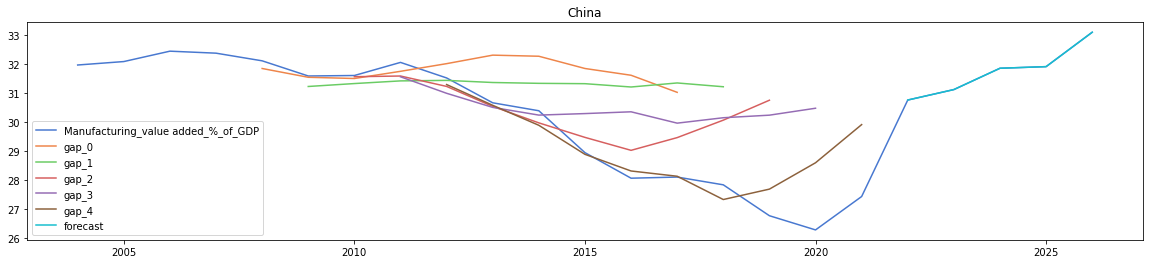

In [ ]:
cmap = sns.color_palette('muted', 6).as_hex()[:]
cmap.append('#17becf')
fcst = forecast(rbscaler, scaled_data, model, IW=IW)
fcst['forecast'] = fcst['Manufacturing_value added_%_of_GDP']
pd.concat(
  [pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1),
   fcst
  ]
).plot(figsize = (20, 4), title = 'China', color = cmap)

##### Residuals

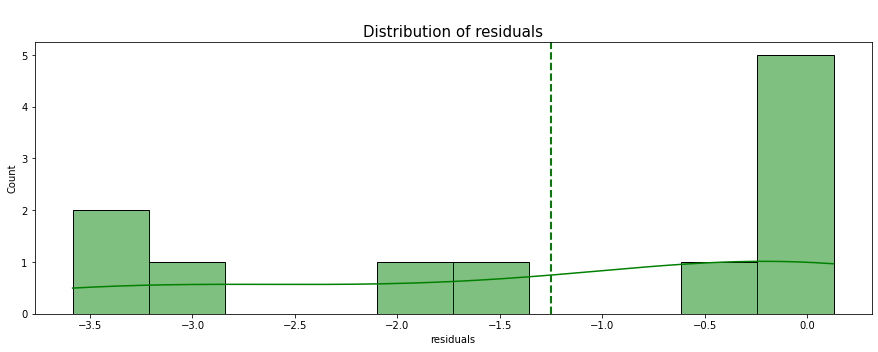

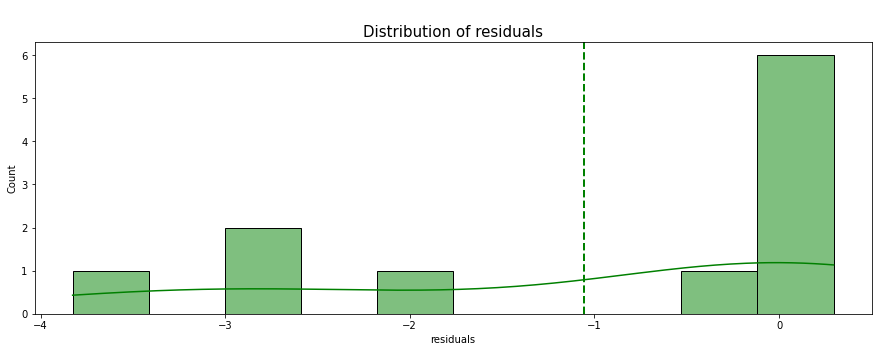

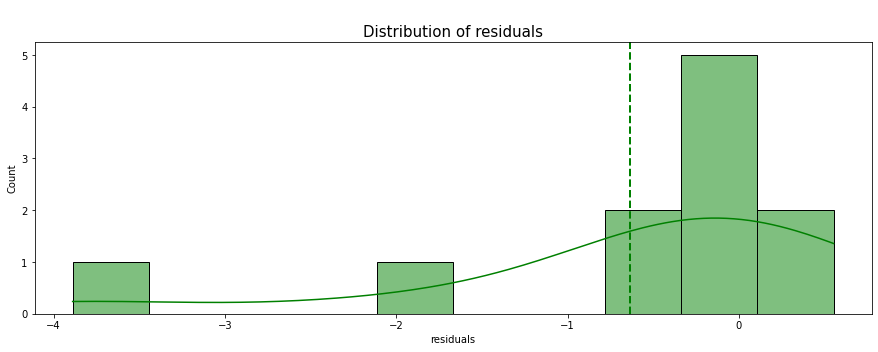

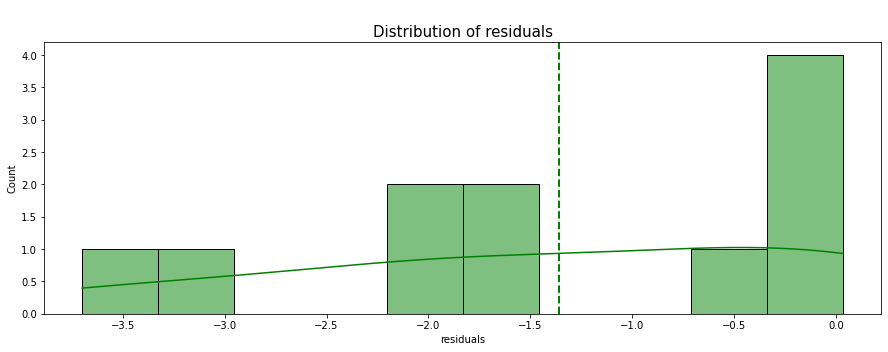

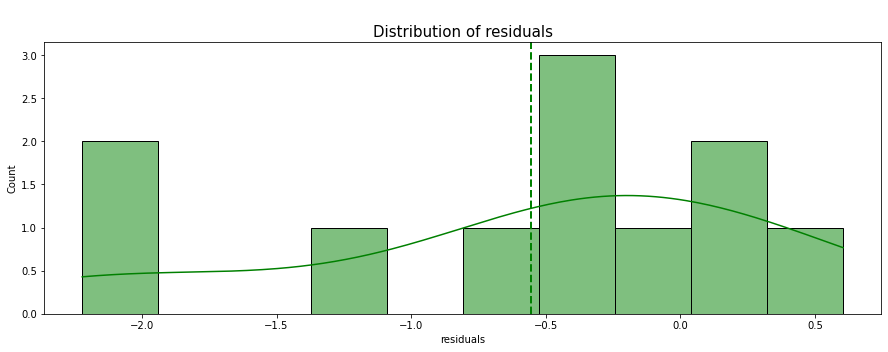

In [ ]:
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  fig, axs = plt.subplots(1, 1, figsize =(15,5), sharex=True)
  sns.histplot(data=pd_res, x="residuals", bins= 10, kde=True, color= 'g')
  plt.axvline(pd_res.residuals.mean(), color='green', linestyle='dashed', linewidth=2)
  plt.title('\nDistribution of residuals', fontsize = 15)

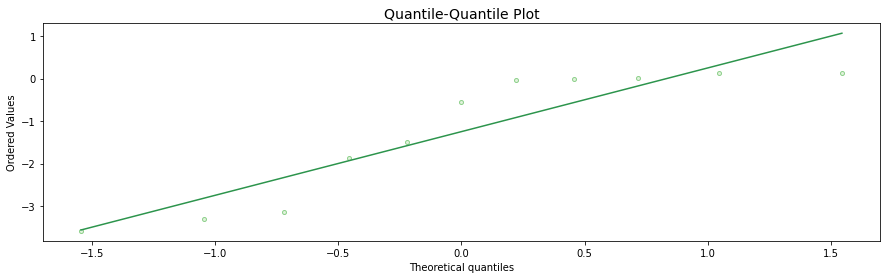

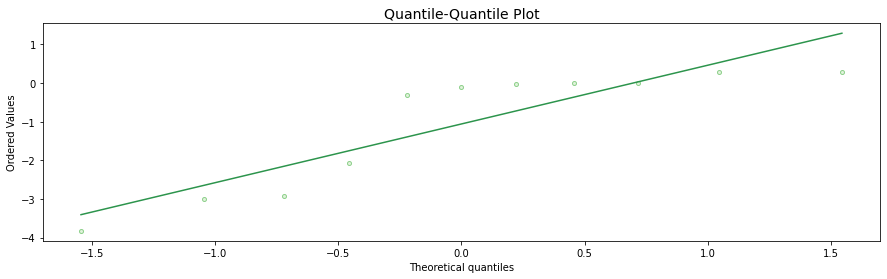

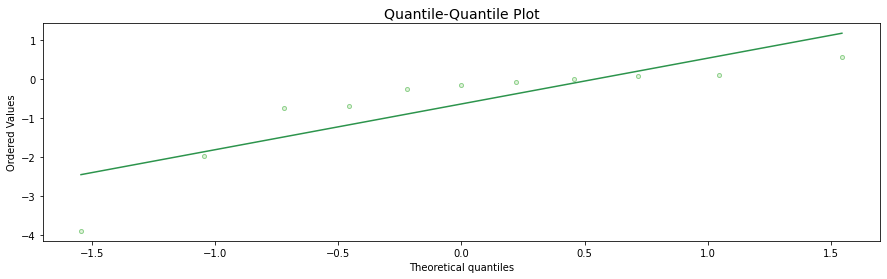

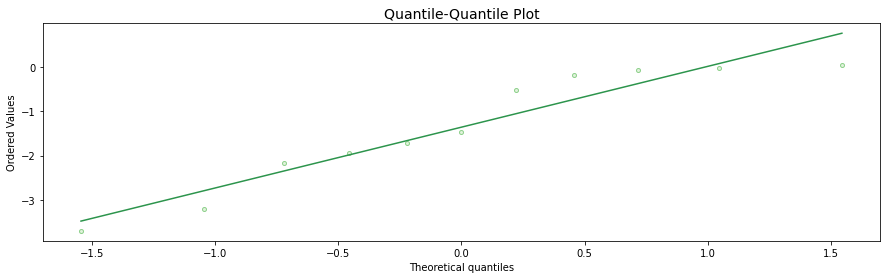

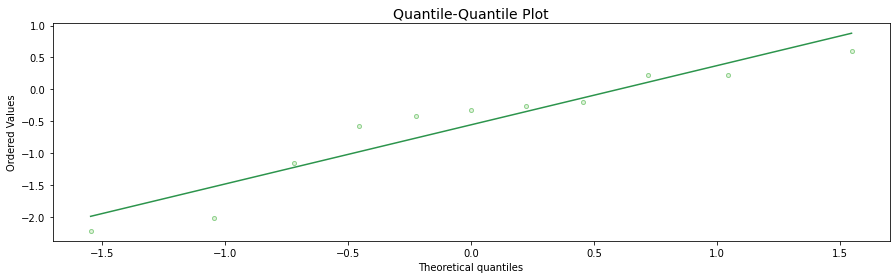

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats
base_green =  sns.color_palette("Greens").as_hex()
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  fig, ax = plt.subplots(figsize=(15, 4))
  stats.probplot(pd_res.residuals.dropna().values,plot=plt, fit=True, dist = stats.norm)
  ax.get_lines()[1].set_color(base_green[-2])
  ax.get_lines()[0].set_color(base_green[2])
  ax.get_lines()[0].set_marker('o')
  ax.get_lines()[0].set_markerfacecolor(base_green[0])
  ax.get_lines()[0].set_markersize(4)
  plt.title('Quantile-Quantile Plot', fontsize = 14)

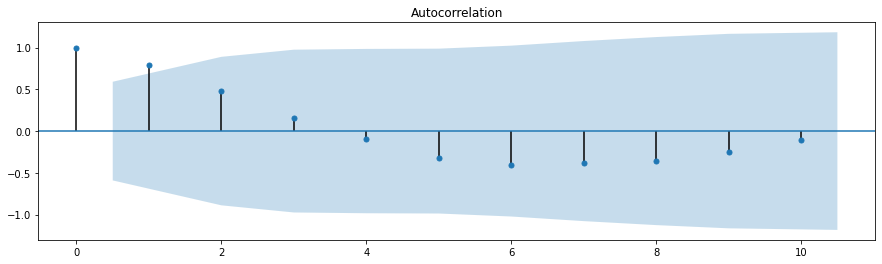

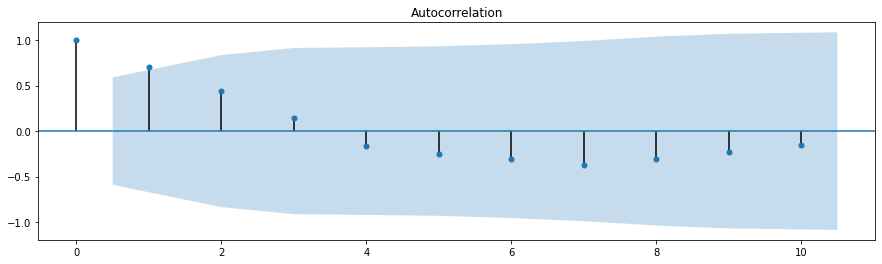

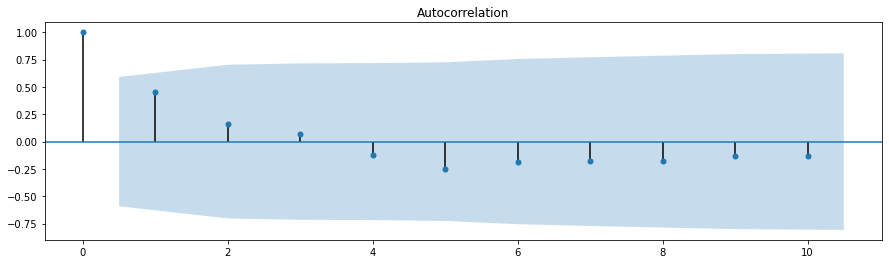

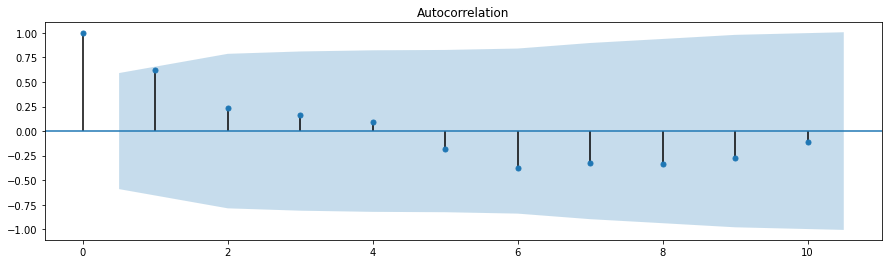

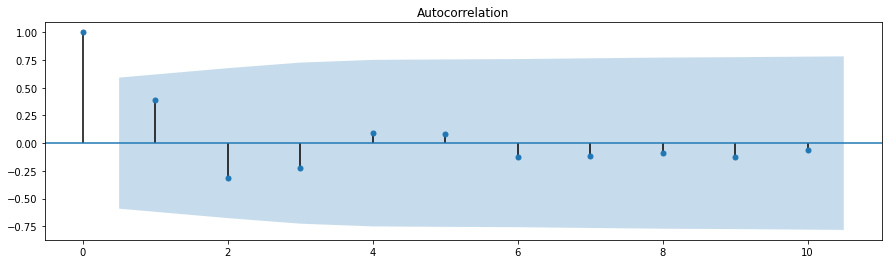

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  plt.figure(figsize=(15, 4))
  plot_acf(pd_res.residuals.dropna().values, ax=plt.gca()).show()

#### China - Median - Uni

In [ ]:
data = m_dfs['CHN']
data = clean_nan(data)
data = data[['Manufacturing_value added_%_of_GDP']]
rbscaler = MRobustScaler() 
scaled_data = rbscaler.transform(data, 0.1)

train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
# use 4 year to predict 1 year ahead
wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                     train_df = train_df, val_df = val_df, test_df = test_df, 
                     scaled_data = scaled_data,
                     label_columns=[scaled_data.columns[-1]])
wg

Total window size: 8
Input indices: [0 1 2]
Label indices: [3 4 5 6 7]
Label column name(s): ['Manufacturing_value added_%_of_GDP']

In [ ]:
model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.1760 - val_loss: 0.4718
Epoch 2/50
1/1 [==============================] - 0s 82ms/step - loss: 0.1694 - val_loss: 0.4755
Epoch 3/50
1/1 [==============================] - 0s 82ms/step - loss: 0.1618 - val_loss: 0.4806
Epoch 4/50
1/1 [==============================] - 0s 80ms/step - loss: 0.1516 - val_loss: 0.4873
Epoch 5/50
1/1 [==============================] - 0s 87ms/step - loss: 0.1382 - val_loss: 0.4969
Epoch 6/50
1/1 [==============================] - 0s 80ms/step - loss: 0.1212 - val_loss: 0.5132
Epoch 7/50
1/1 [==============================] - 0s 84ms/step - loss: 0.1101 - val_loss: 0.5343
Epoch 8/50
1/1 [==============================] - 0s 81ms/step - loss: 0.1109 - val_loss: 0.5485
Epoch 9/50
1/1 [==============================] - 0s 80ms/step - loss: 0.1208 - val_loss: 0.5484
Epoch 10/50
1/1 [==============================] - 0s 78ms/step - loss: 0.1207 - val_loss: 0.5377
Epoch 11/50
1/1 [==============

In [ ]:
y_pred, y_real = fetch_pred_real(rbscaler, model)
print(
'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
'\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
'\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
)

1/1 [==============================] - 1s 863ms/step
MAE [3.4601097, 3.50943, 3.7846496, 4.326593, 3.8967533]  Mean MAE 3.7955077 
MSE [12.0983, 12.324754, 14.568694, 19.051214, 15.404514]  Mean MSE 14.689496 
RMSE [3.478261, 3.5106628, 3.816896, 4.3647695, 3.9248586] Mean RMSE 3.8326879


##### plot

1/1 [==============================] - 0s 39ms/step


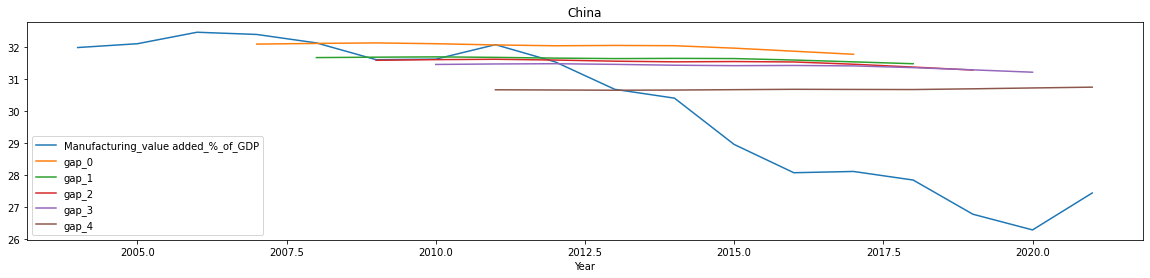

In [ ]:
y_pred, y_real = fetch_all_pred_real(rbscaler, model)
### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1).plot(figsize = (20, 4), title = 'China')

###### Forecast

In [ ]:
forecast(rbscaler, scaled_data, model, 'China')

1/1 [==============================] - 0s 19ms/step


,China
2022,31.393614
2023,31.245255
2024,30.937243
2025,30.954990
2026,30.862019


###### Residuals

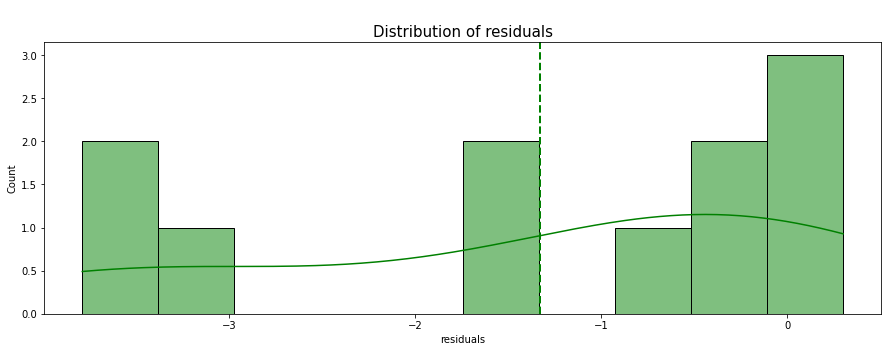

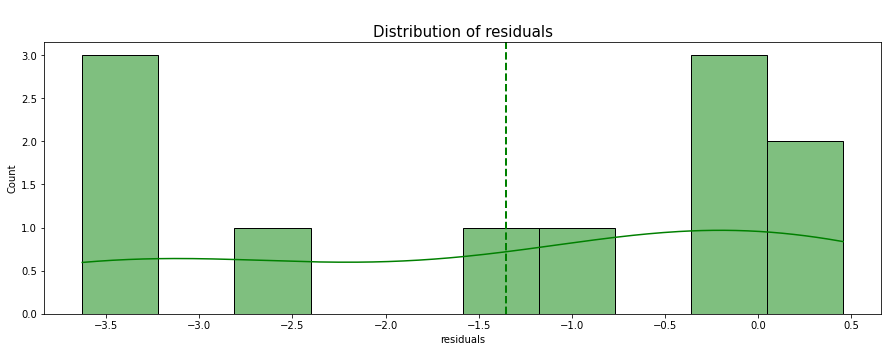

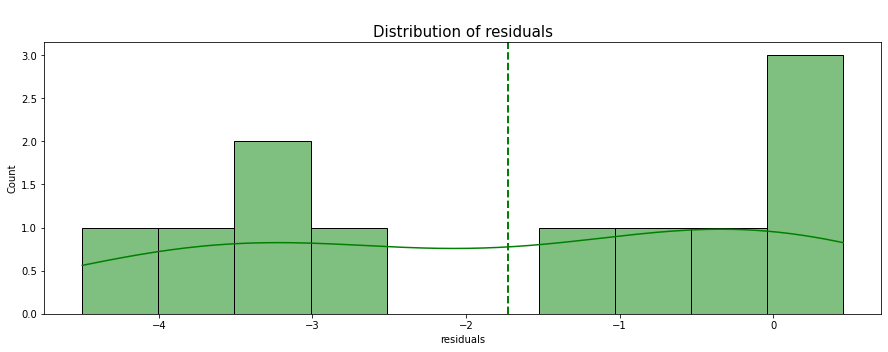

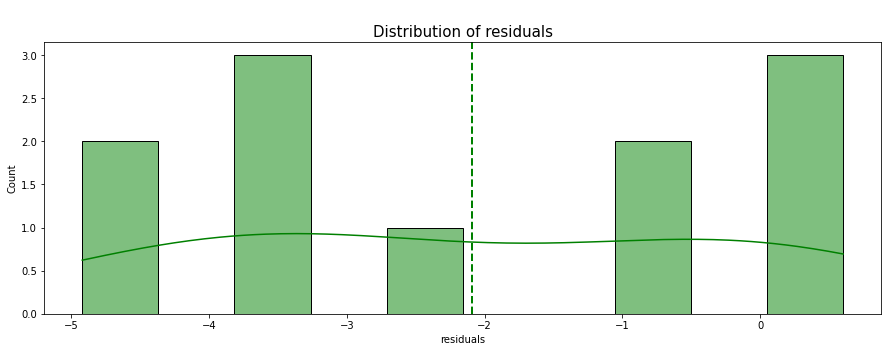

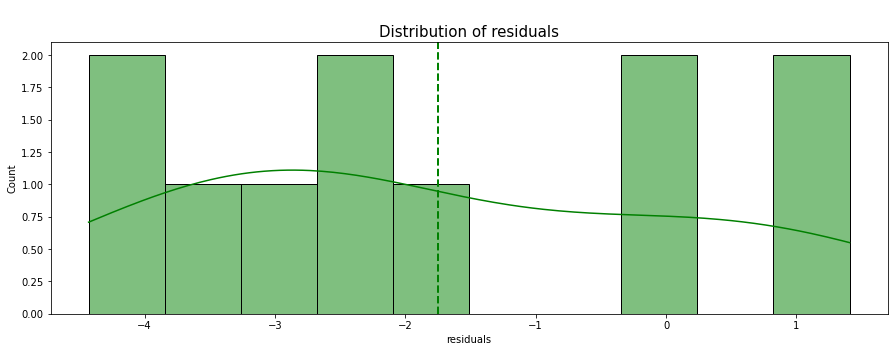

In [ ]:
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  fig, axs = plt.subplots(1, 1, figsize =(15,5), sharex=True)
  sns.histplot(data=pd_res, x="residuals", bins= 10, kde=True, color= 'g')
  plt.axvline(pd_res.residuals.mean(), color='green', linestyle='dashed', linewidth=2)
  plt.title('\nDistribution of residuals', fontsize = 15)

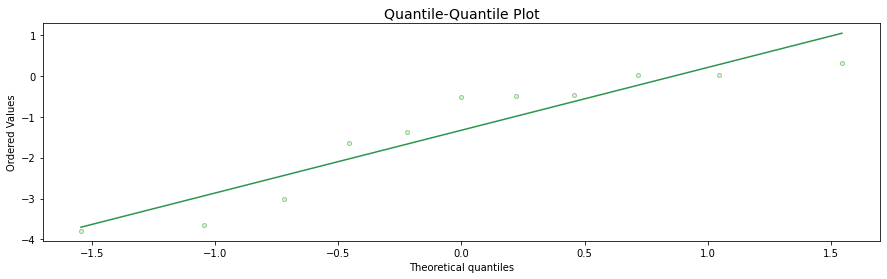

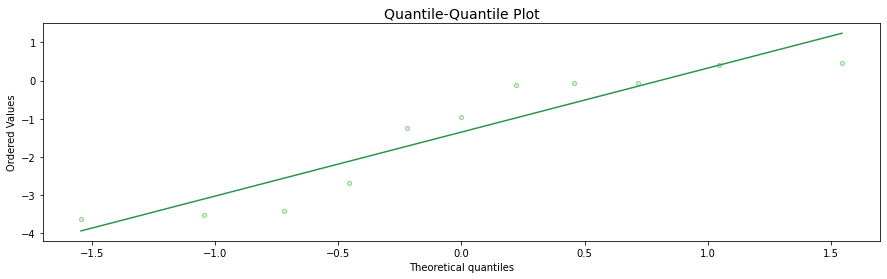

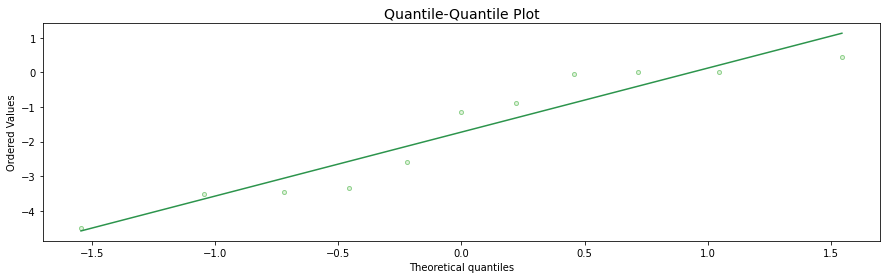

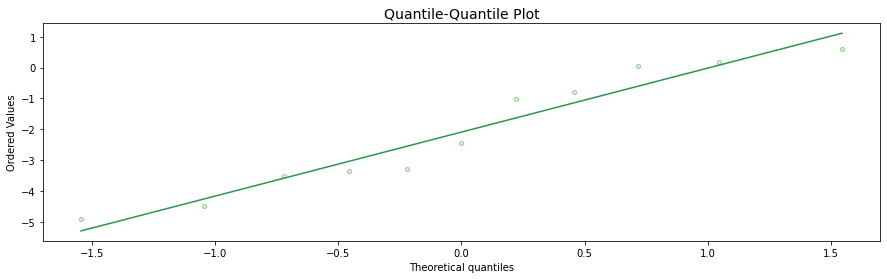

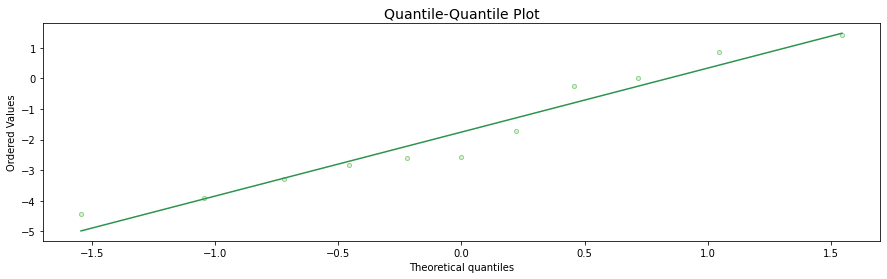

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats
base_green =  sns.color_palette("Greens").as_hex()
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  fig, ax = plt.subplots(figsize=(15, 4))
  stats.probplot(pd_res.residuals.dropna().values,plot=plt, fit=True, dist = stats.norm)
  ax.get_lines()[1].set_color(base_green[-2])
  ax.get_lines()[0].set_color(base_green[2])
  ax.get_lines()[0].set_marker('o')
  ax.get_lines()[0].set_markerfacecolor(base_green[0])
  ax.get_lines()[0].set_markersize(4)
  plt.title('Quantile-Quantile Plot', fontsize = 14)

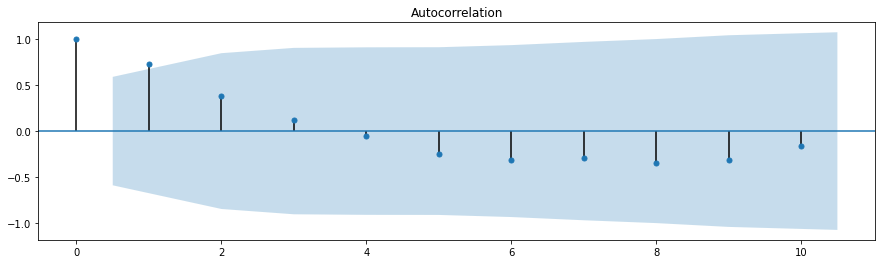

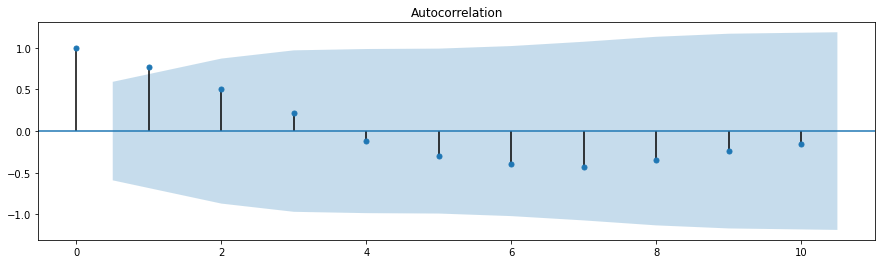

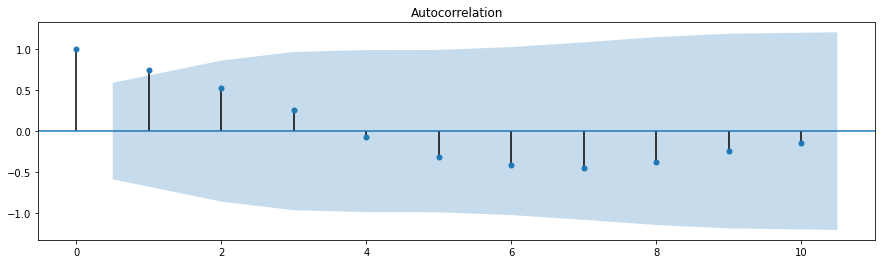

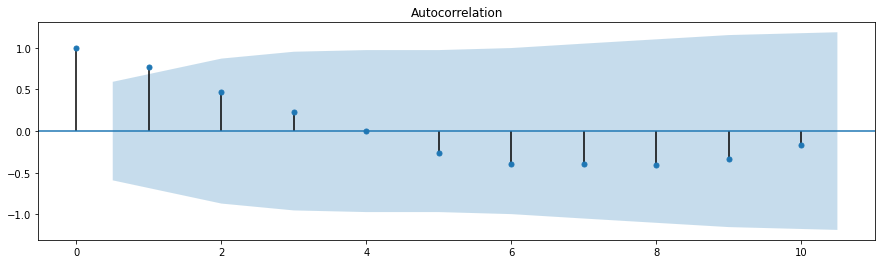

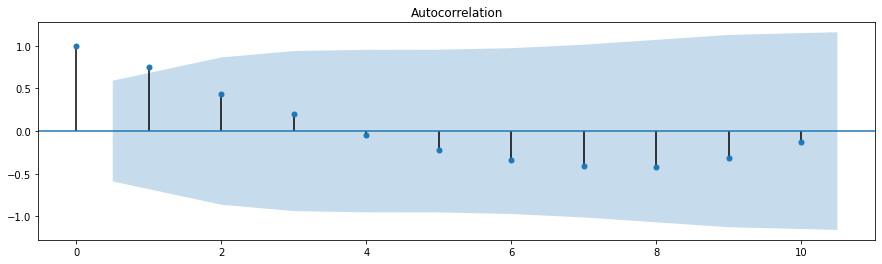

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  plt.figure(figsize=(15, 4))
  plot_acf(pd_res.residuals.dropna().values, ax=plt.gca()).show()

#### India

###### multi

In [ ]:
data = m_dfs['IND']
data = clean_nan(data)
rbscaler = MRobustScaler() 
scaled_data = rbscaler.transform(data, 0.1)
train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
# use 4 year to predict 1 year ahead
wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                     train_df = train_df, val_df = val_df, test_df = test_df, 
                     scaled_data = scaled_data,
                     label_columns=[scaled_data.columns[-1]])
model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
y_pred, y_real = fetch_pred_real(rbscaler, model)
print(
'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
'\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
'\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
)

Epoch 1/50
2/2 [==============================] - 5s 971ms/step - loss: 0.4982 - val_loss: 0.3673
Epoch 2/50
2/2 [==============================] - 0s 84ms/step - loss: 0.4894 - val_loss: 0.4033
Epoch 3/50
2/2 [==============================] - 0s 89ms/step - loss: 0.4820 - val_loss: 0.4153
Epoch 4/50
2/2 [==============================] - 0s 79ms/step - loss: 0.4717 - val_loss: 0.4069
Epoch 5/50
2/2 [==============================] - 0s 80ms/step - loss: 0.4616 - val_loss: 0.4141
Epoch 6/50
2/2 [==============================] - 0s 78ms/step - loss: 0.4444 - val_loss: 0.4404
Epoch 7/50
2/2 [==============================] - 0s 81ms/step - loss: 0.4187 - val_loss: 0.4697
Epoch 8/50
2/2 [==============================] - 0s 79ms/step - loss: 0.3994 - val_loss: 0.5069
Epoch 9/50
2/2 [==============================] - 0s 78ms/step - loss: 0.3974 - val_loss: 0.5280
Epoch 10/50
2/2 [==============================] - 0s 79ms/step - loss: 0.3811 - val_loss: 0.5201
Epoch 11/50
2/2 [===========

In [ ]:
def fetch_all_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.all_data)
  y_pred = np.array(y_pred)*qrange+target_median
  y = None
  for _, j in  model.data_window.all_data:
    if y is None:
      y = j*qrange+target_median
    else:
      y = np.concatenate((y, j*qrange+target_median))
  y_real = y.reshape(y_pred.shape)
  return y_pred, y_real

1/1 [==============================] - 1s 829ms/step


,China
2022,15.379866
2023,14.978136
2024,14.755605
2025,14.819216
2026,14.587652


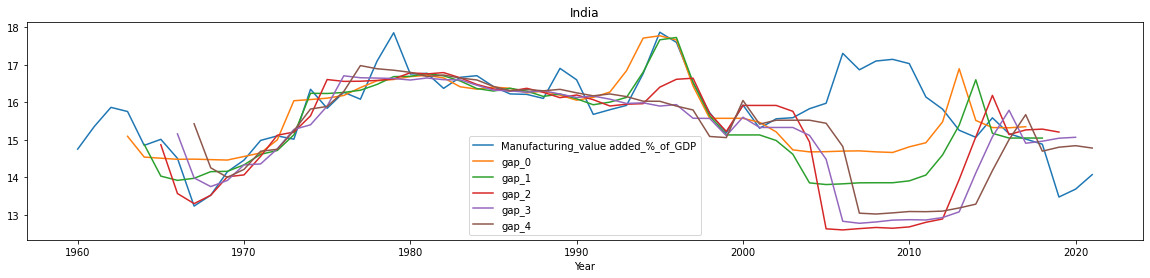

In [ ]:
y_pred, y_real = fetch_all_pred_real(rbscaler, model)
### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1).plot(figsize = (20, 4), title = 'India')
forecast(rbscaler, scaled_data, model, 'China')

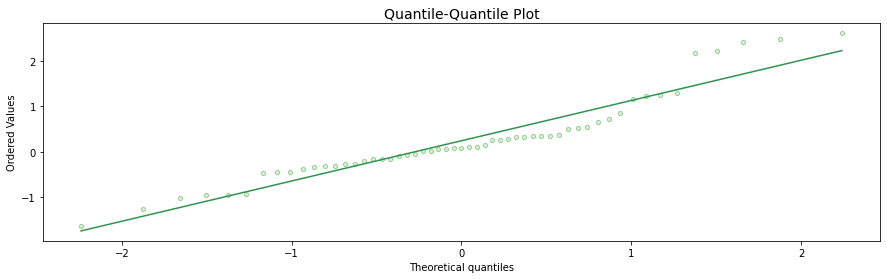

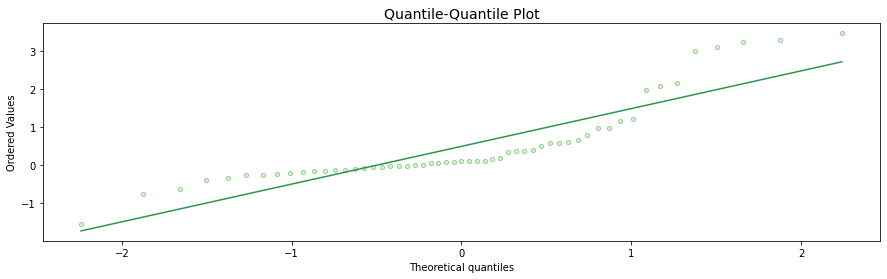

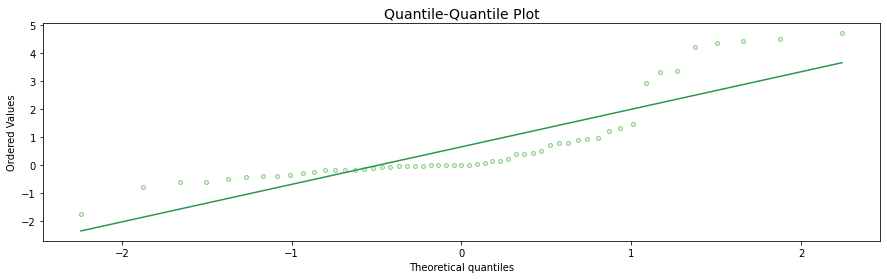

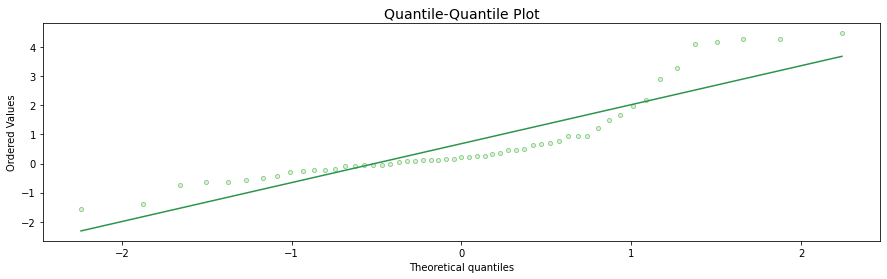

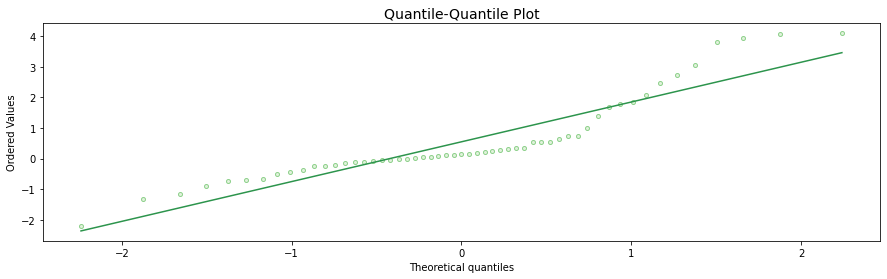

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats
base_green =  sns.color_palette("Greens").as_hex()
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  fig, ax = plt.subplots(figsize=(15, 4))
  stats.probplot(pd_res.residuals.dropna().values,plot=plt, fit=True, dist = stats.norm)
  ax.get_lines()[1].set_color(base_green[-2])
  ax.get_lines()[0].set_color(base_green[2])
  ax.get_lines()[0].set_marker('o')
  ax.get_lines()[0].set_markerfacecolor(base_green[0])
  ax.get_lines()[0].set_markersize(4)
  plt.title('Quantile-Quantile Plot', fontsize = 14)

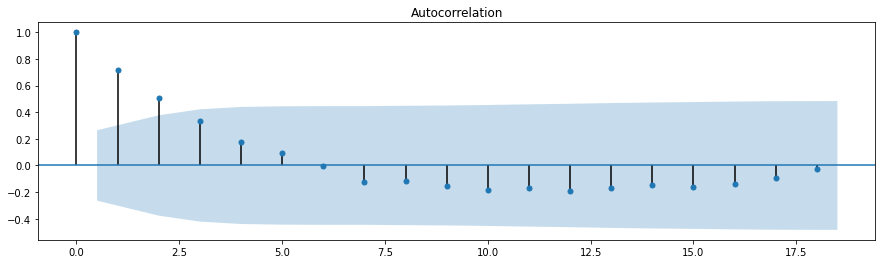

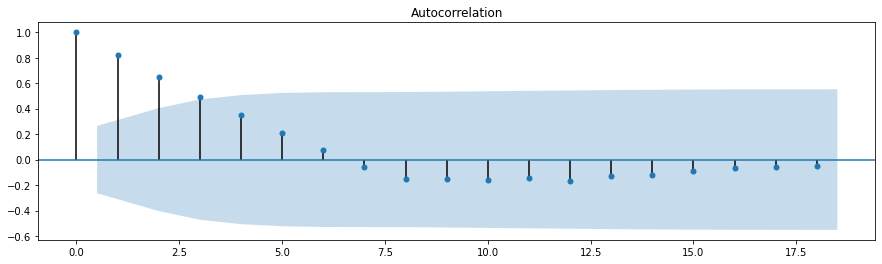

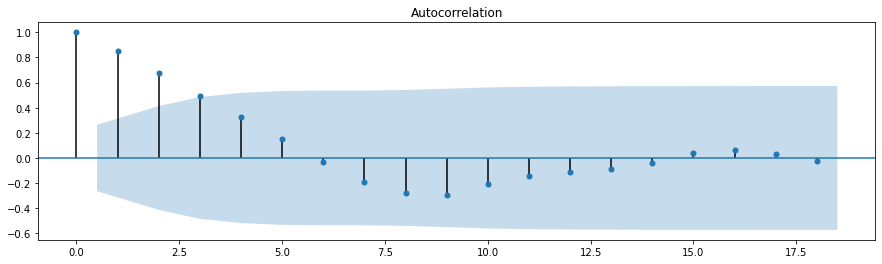

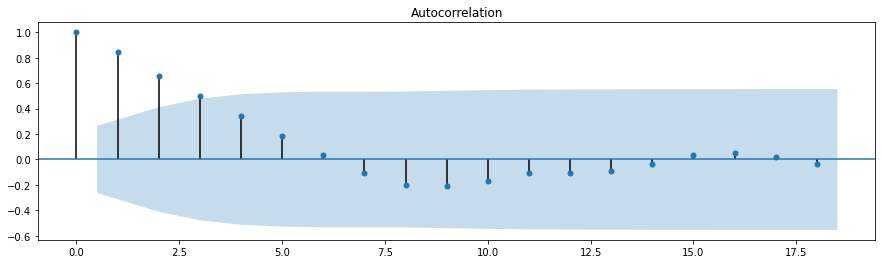

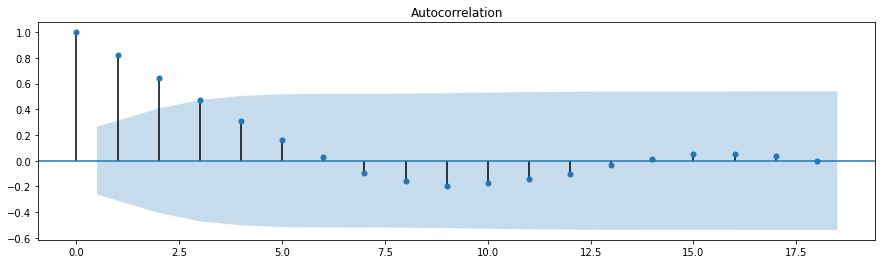

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  plt.figure(figsize=(15, 4))
  plot_acf(pd_res.residuals.dropna().values, ax=plt.gca()).show()

##### uni

In [ ]:
data = m_dfs['IND']
data = clean_nan(data)
data = data[['Manufacturing_value added_%_of_GDP']]
rbscaler = MRobustScaler() 
scaled_data = rbscaler.transform(data, 0.1)
train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
# use 4 year to predict 1 year ahead
wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                     train_df = train_df, val_df = val_df, test_df = test_df, 
                     scaled_data = scaled_data,
                     label_columns=[scaled_data.columns[-1]])
model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
y_pred, y_real = fetch_pred_real(rbscaler, model)
print(
'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
'\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
'\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
)

Epoch 1/50
2/2 [==============================] - 6s 949ms/step - loss: 0.4980 - val_loss: 0.3680
Epoch 2/50
2/2 [==============================] - 0s 106ms/step - loss: 0.4921 - val_loss: 0.3653
Epoch 3/50
2/2 [==============================] - 0s 110ms/step - loss: 0.4876 - val_loss: 0.3640
Epoch 4/50
2/2 [==============================] - 0s 113ms/step - loss: 0.4821 - val_loss: 0.3629
Epoch 5/50
2/2 [==============================] - 0s 96ms/step - loss: 0.4766 - val_loss: 0.3630
Epoch 6/50
2/2 [==============================] - 0s 103ms/step - loss: 0.4755 - val_loss: 0.3645
Epoch 7/50
2/2 [==============================] - 0s 97ms/step - loss: 0.4751 - val_loss: 0.3646
Epoch 8/50
2/2 [==============================] - 0s 102ms/step - loss: 0.4757 - val_loss: 0.3648
Epoch 9/50
2/2 [==============================] - 0s 95ms/step - loss: 0.4753 - val_loss: 0.3645
Epoch 10/50
2/2 [==============================] - 0s 102ms/step - loss: 0.4750 - val_loss: 0.3639
Epoch 11/50
2/2 [=====

1/1 [==============================] - 0s 27ms/step


,India
2022,14.213396
2023,14.674888
2024,15.114841
2025,15.272189
2026,15.910675


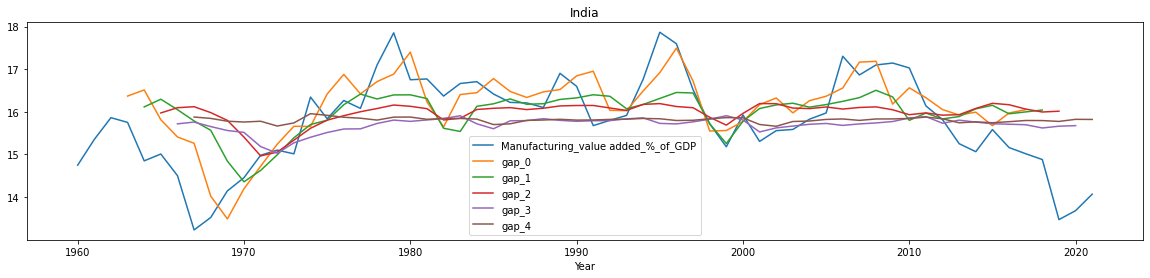

In [ ]:
y_pred, y_real = fetch_all_pred_real(rbscaler, model)
### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1).plot(figsize = (20, 4), title = 'India')
forecast(rbscaler, scaled_data, model, 'India')

###### Residuals

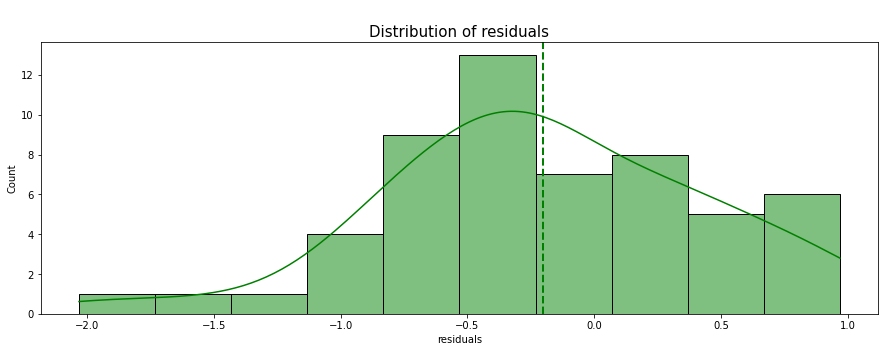

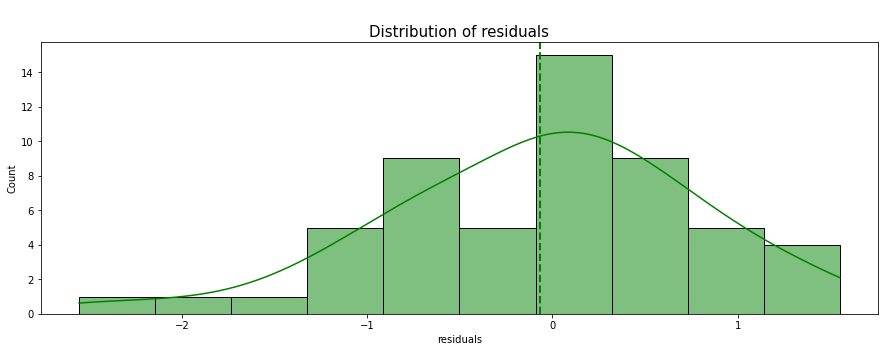

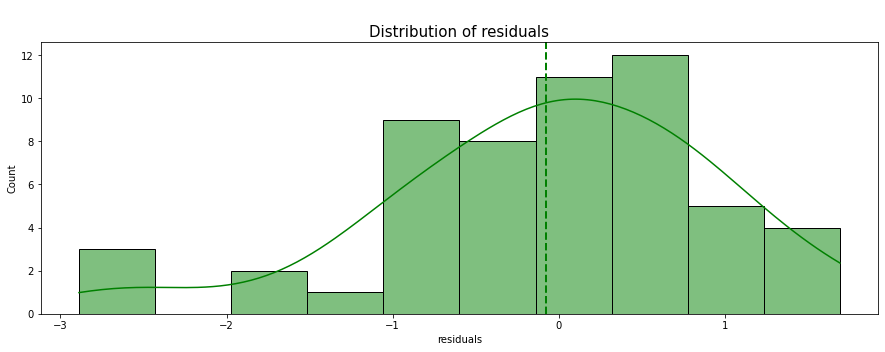

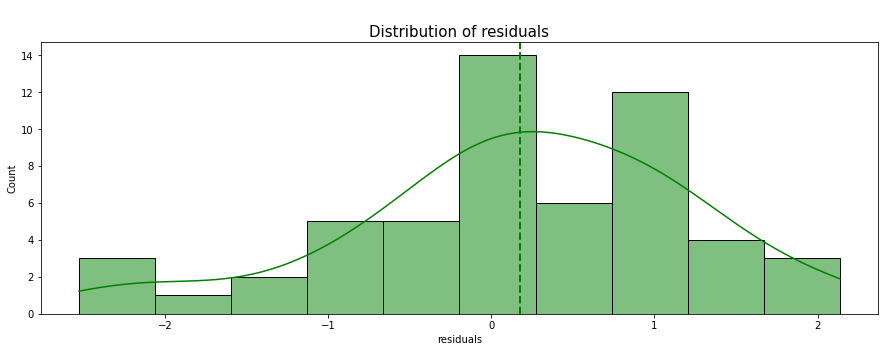

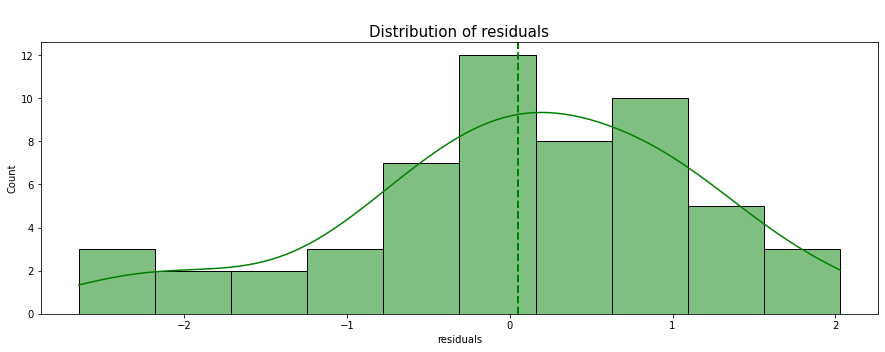

In [ ]:
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  fig, axs = plt.subplots(1, 1, figsize =(15,5), sharex=True)
  sns.histplot(data=pd_res, x="residuals", bins= 10, kde=True, color= 'g')
  plt.axvline(pd_res.residuals.mean(), color='green', linestyle='dashed', linewidth=2)
  plt.title('\nDistribution of residuals', fontsize = 15)

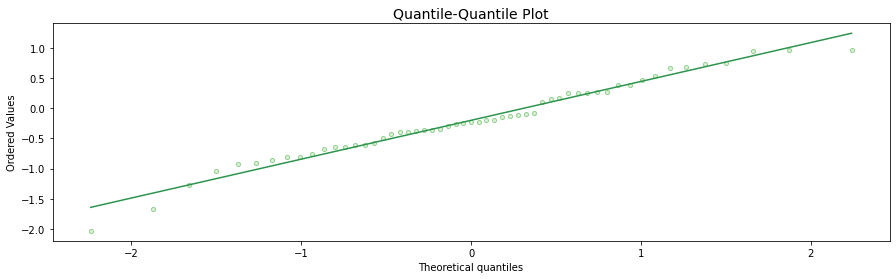

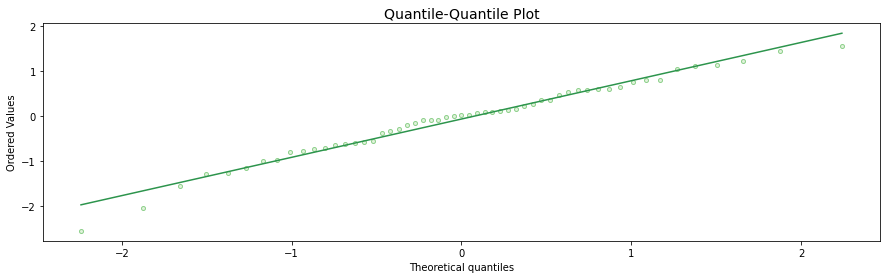

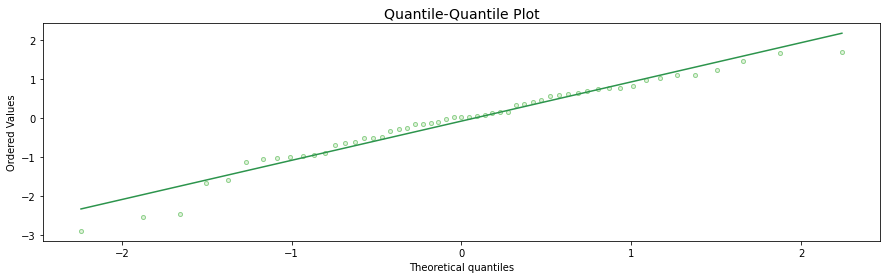

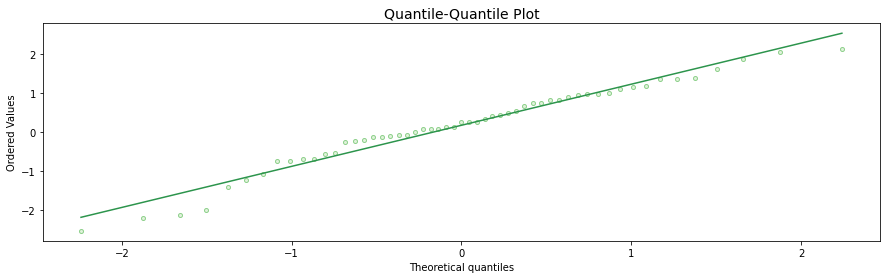

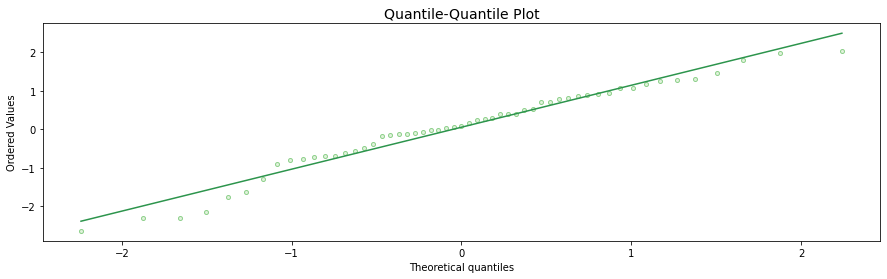

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats
base_green =  sns.color_palette("Greens").as_hex()
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  fig, ax = plt.subplots(figsize=(15, 4))
  stats.probplot(pd_res.residuals.dropna().values,plot=plt, fit=True, dist = stats.norm)
  ax.get_lines()[1].set_color(base_green[-2])
  ax.get_lines()[0].set_color(base_green[2])
  ax.get_lines()[0].set_marker('o')
  ax.get_lines()[0].set_markerfacecolor(base_green[0])
  ax.get_lines()[0].set_markersize(4)
  plt.title('Quantile-Quantile Plot', fontsize = 14)

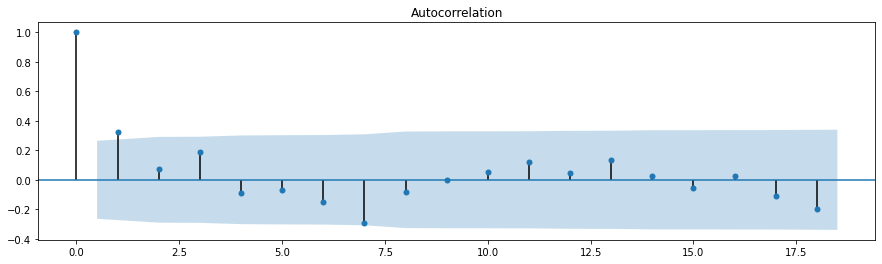

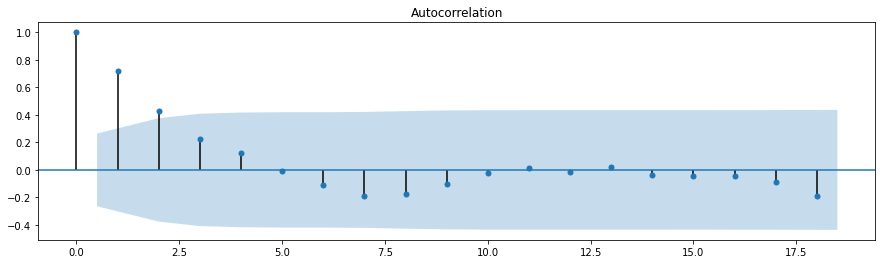

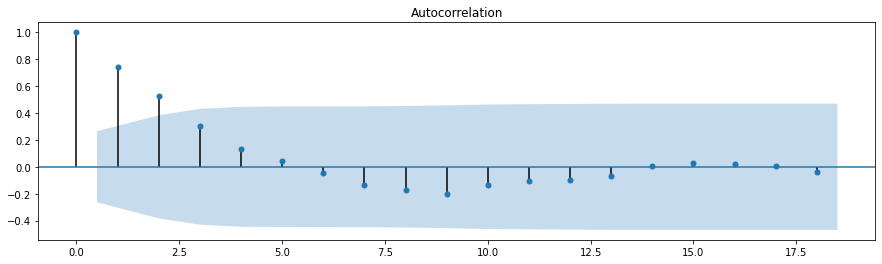

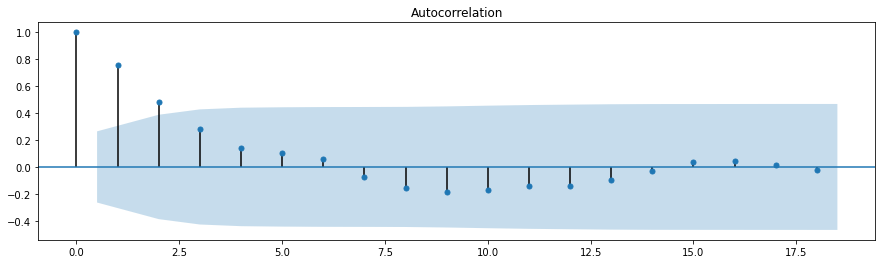

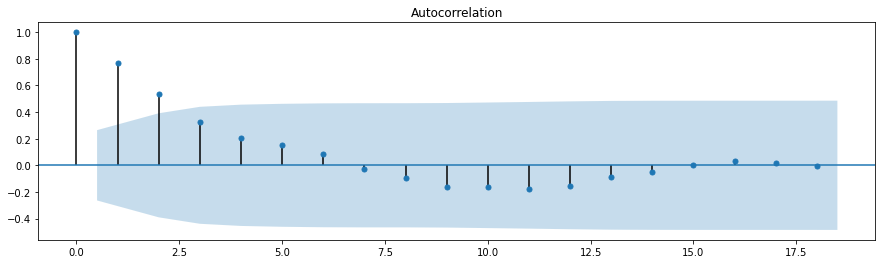

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
for i in range(5):
  pd_res = pd.DataFrame({'residuals':y_real[:, i]  - y_pred[:, i]})
  plt.figure(figsize=(15, 4))
  plot_acf(pd_res.residuals.dropna().values, ax=plt.gca()).show()